In [313]:
%matplotlib widget
import subprocess
import re
import requests
import rasterio
from rasterio import features
import shapely.geometry
import geopandas
import matplotlib.pyplot as plt
import contextily
import cc3d

In [420]:
scale = 20
height = 180*scale
width = 360*scale
date = '2017-12-11'

url = f'''https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?version=1.1.1
         &service=WMS
         &request=GetMap
         &format=image/png
         &STYLE=default
         &bbox=-180,-90,180,90
         &SRS=EPSG:4326
         &HEIGHT={height}
         &WIDTH={width}
         &TIME={date}
         &layers=OrbitTracks_Terra_Descending_Lines'''

In [421]:
url =str.join('', re.sub('\n', '', url).split())
out = '-Oimage.png'
subprocess.run(['wget', url, out])

--2022-11-10 17:40:36--  https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?version=1.1.1&service=WMS&request=GetMap&format=image/png&STYLE=default&bbox=-180,-90,180,90&SRS=EPSG:4326&HEIGHT=3600&WIDTH=7200&TIME=2017-12-11&layers=OrbitTracks_Terra_Descending_Lines
Resolving gibs.earthdata.nasa.gov (gibs.earthdata.nasa.gov)... 198.118.199.5, 2001:4d0:241a:442::5
Connecting to gibs.earthdata.nasa.gov (gibs.earthdata.nasa.gov)|198.118.199.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘image.png’

     0K .......... .......... .......... .......... ..........  186K
    50K .......... .......... .......... .......... .......... 61.5M
   100K .......... .......... .......... .......... ..........  668K
   150K .......... .......... .......... .......... ..........  475K
   200K .......... .......... .......... .......... ..........  337K
   250K .......... .......... .......... .......... ..........  432K
   300K ........

CompletedProcess(args=['wget', 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?version=1.1.1&service=WMS&request=GetMap&format=image/png&STYLE=default&bbox=-180,-90,180,90&SRS=EPSG:4326&HEIGHT=3600&WIDTH=7200&TIME=2017-12-11&layers=OrbitTracks_Terra_Descending_Lines', '-Oimage.png'], returncode=0)

In [428]:
with rasterio.open('image.png') as src:
    img = src.read(1)
img = (img >0)*1
img = cc3d.connected_components(img)
mask = img != 0

transform = rasterio.Affine(1/scale, 0, -180, 0, -1/scale, 90)
shapes = features.shapes(img, mask=mask, transform=transform)

In [429]:
geometries = []
colvalues = []
for (geom, colval) in shapes:
    geometries.append(shapely.geometry.Polygon(geom["coordinates"][0]))
    colvalues.append(colval)

In [439]:
gdf = geopandas.GeoDataFrame({"value": colvalues, "geometry": geometries})
gdf.to_file(f'{date}_orbit_tracks.gpkg', driver='GPKG')

ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: webmerc: Invalid latitude
ERROR 1: PROJ: w

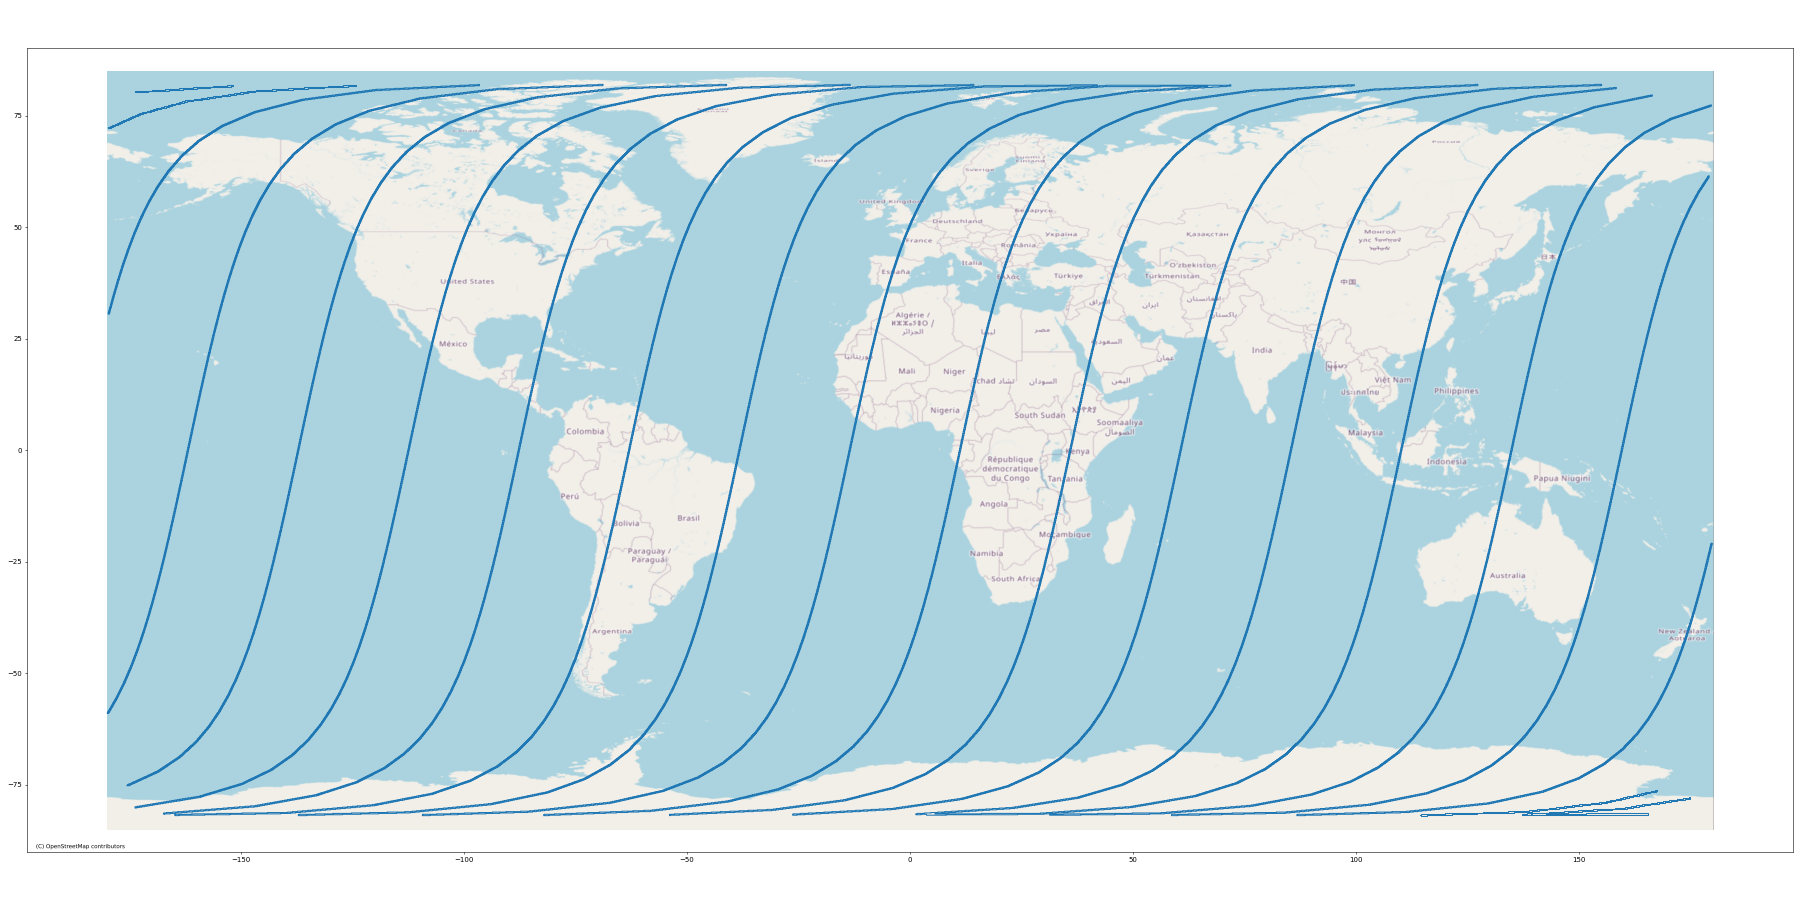

In [424]:
fig, ax = plt.subplots(figsize=(36, 18), dpi=50)
gdf.exterior.plot(ax=ax)
fig.tight_layout()
contextily.add_basemap(ax, source=contextily.providers.OpenStreetMap.Mapnik, crs=4326)

In [474]:
def to_line(row):
    x, y = row.geometry.exterior.xy
    x = x[0:round(len(x)/2)]
    y = y[0:round(len(y)/2)]
    return shapely.geometry.LineString(zip(x,y))

In [476]:
gdf.geometry = gdf.apply(to_line, axis=1)

/home/griessbaum/.virtualenvs/starepandas/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<AxesSubplot:>

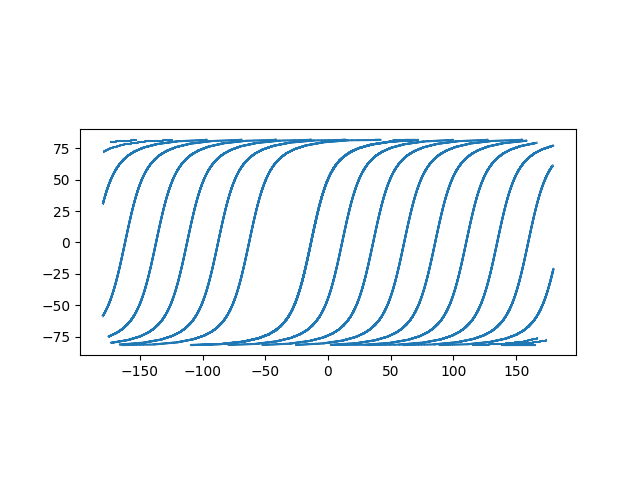

In [477]:
gdf.plot()